In [1]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [2]:
L = 12
J = 1
h = 0.05
lamb = 0.7

x_basis = False

particle_pair_left_position = L//2 - 1
particle_pair_length = 1

final_time = 8
layers = 25
measure_every_layers = 1

# Device selection

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance
# from fradm.tokens import ibm_token, group_instance

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
device = "ibm_torino"

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance)
backend = service.backend(device)

# Circuit transpilation

Longest circuit has 100 2-qb depth


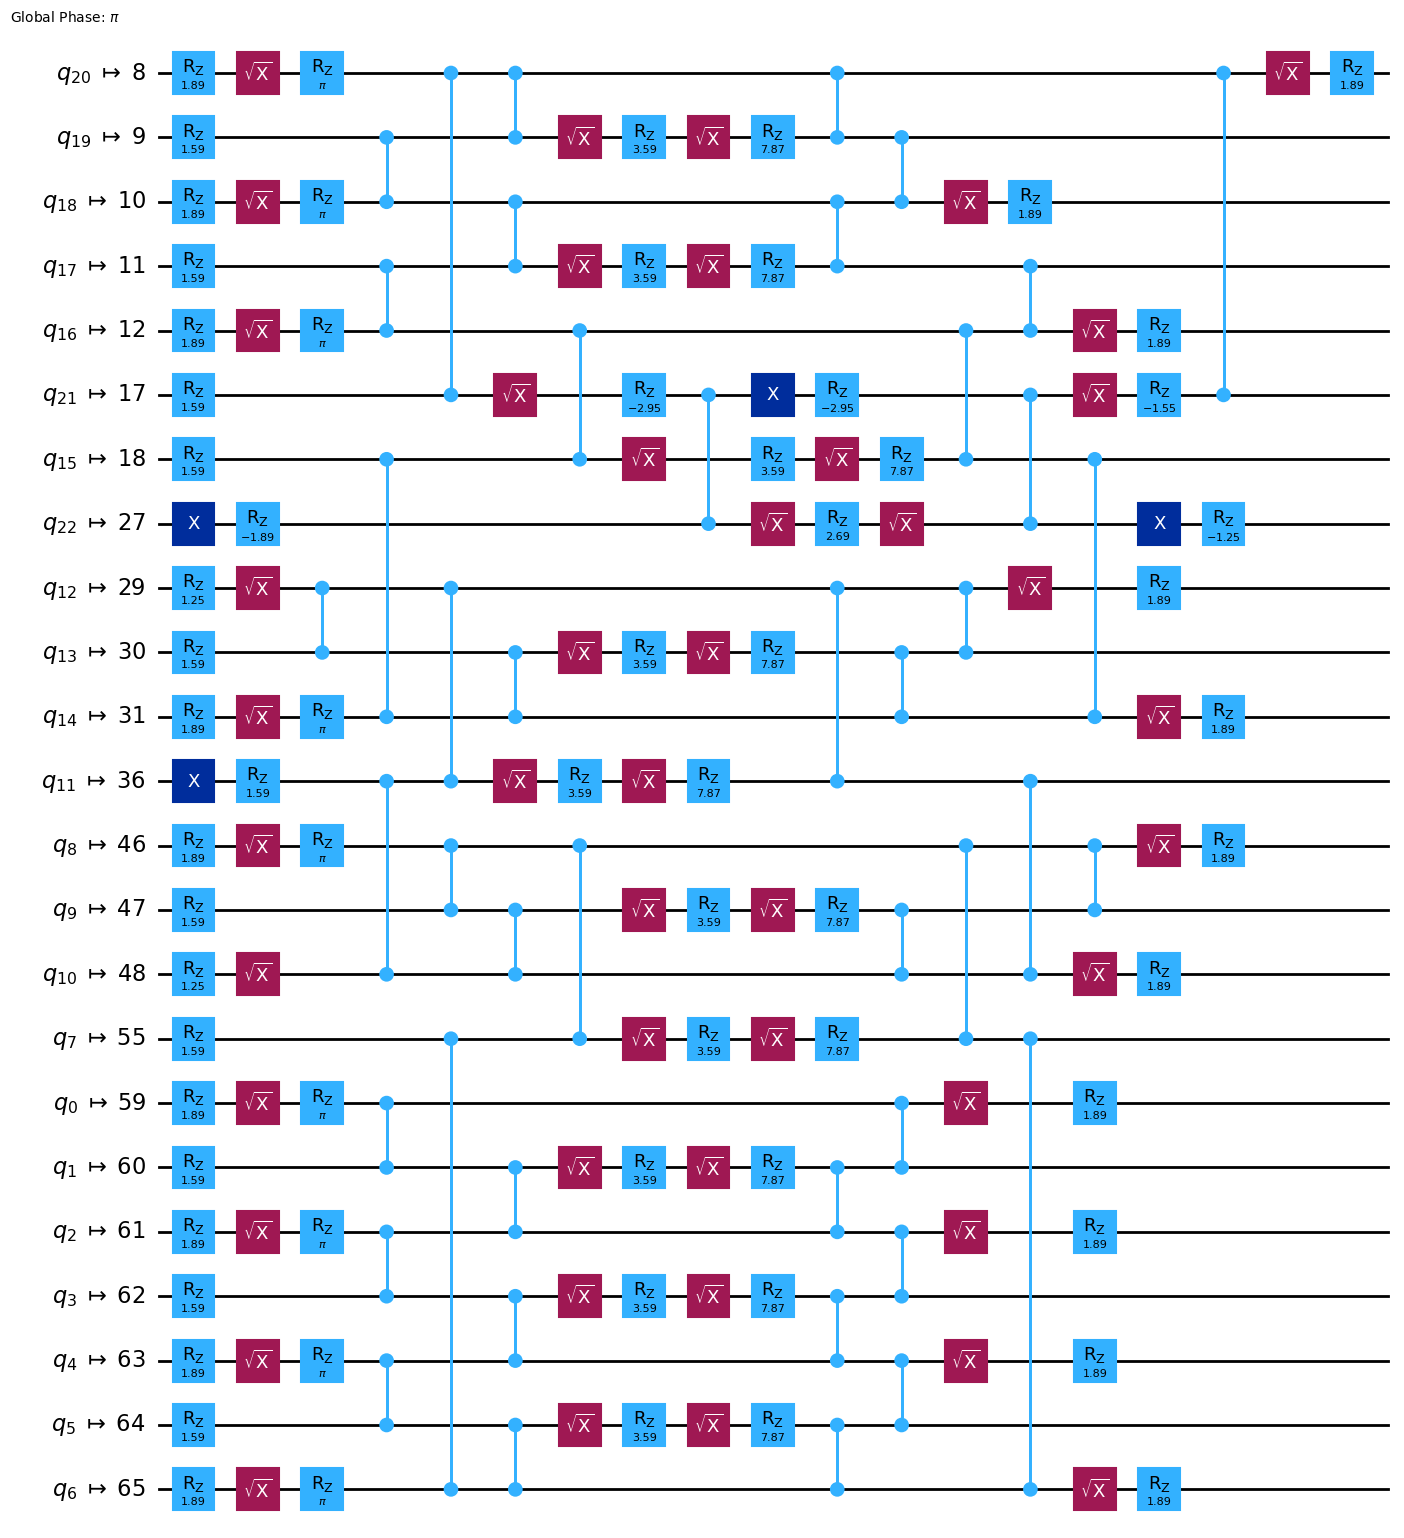

In [4]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits

optimization_level = 2

qubits_inds = None
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22]
# qubits_inds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 16,
#                26, 25, 24, 23, 22, 21, 20, 33, 39, 40,
#                41, 42, 43, 44, 45, 54, 64, 63, 62, 72, 
#                81, 82, 83, 92, 102, 103, 104, 111, 122,
#                121, 120, 119, 118, 116, 115, 114, 109, 96, 95]

physical_circuits = physical_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, backend, optimization_level, qubits_inds, measure_every_layers=measure_every_layers, x_basis=x_basis)
longest_2qb_depth = physical_circuits[-1].depth(lambda x: len(x.qubits) == 2)
print(f"Longest circuit has {longest_2qb_depth} 2-qb depth")
physical_circuits[1].draw(output="mpl", idle_wires=False, fold=-1, filename="transpiled_circuit.png")

# Estimator circuit execution

### Options

In [5]:
from utils.hexec import ExecDB

execution_database = "z2_chain_jobs.json"

estimator_options = {
    "default_shots": 10000,
    "optimization_level": 0,
    "resilience_level": 0,
    "resilience": {
        "zne_mitigation": True,
        "measure_mitigation": True,
        "pec_mitigation": False,
        "zne": {
            "extrapolator": "linear", # zne_mitigation
            "noise_factors": [1, 1.2, 1.5]
        }
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": "auto",
        "shots_per_randomization": "auto"
    }
}

job_db = ExecDB(execution_database)

### Observables to measure

In [6]:
from z2chain.operators import local_pauli_z, local_pauli_x
from functools import partial

observable_name = "Occupation numbers" + (" X" if x_basis else " Z")
observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)]

### Send job to hardware

In [52]:
jobs = job_db.execute_estimator_batch(backend, estimator_options, physical_circuits, observable_generating_funcs, observable_name)

### Load last job with the same options

In [7]:
jobs = job_db.search_by_params(estimator_options, physical_circuits, observable_name, strict_depth=False, limit=1, ibmq_service=service)
jobs

[<RuntimeJobV2('cv6vn444p20g008rywp0', 'estimator')>,
 <RuntimeJobV2('cv6vn4w4p20g008rywpg', 'estimator')>,
 <RuntimeJobV2('cv6vn5mw1n8000848cyg', 'estimator')>,
 <RuntimeJobV2('cv6vn7ct5n50008wsyp0', 'estimator')>,
 <RuntimeJobV2('cv6vn95w1n8000848cz0', 'estimator')>,
 <RuntimeJobV2('cv6vn9xmzw70008ev1x0', 'estimator')>,
 <RuntimeJobV2('cv6vnadw1n8000848czg', 'estimator')>,
 <RuntimeJobV2('cv6vnbdmzw70008ev1y0', 'estimator')>,
 <RuntimeJobV2('cv6vnbx39kwg008vxmrg', 'estimator')>,
 <RuntimeJobV2('cv6vnedt5n50008wsyqg', 'estimator')>,
 <RuntimeJobV2('cv6vngpkwkwg008t1e7g', 'estimator')>,
 <RuntimeJobV2('cv6vnhyw1n8000848d00', 'estimator')>,
 <RuntimeJobV2('cv6vnke4p20g008rywrg', 'estimator')>,
 <RuntimeJobV2('cv6vnnemzw70008ev1z0', 'estimator')>,
 <RuntimeJobV2('cv6vnq6kwkwg008t1e90', 'estimator')>,
 <RuntimeJobV2('cv6vnqpt5n50008wsyrg', 'estimator')>,
 <RuntimeJobV2('cv6vnrq39kwg008vxmsg', 'estimator')>,
 <RuntimeJobV2('cv6vnsfkwkwg008t1e9g', 'estimator')>,
 <RuntimeJobV2('cv6vnt7kwkwg

### Load jobs with batch id

In [5]:
session_id = "ctgc5e5q3n6g008fcet0"

jobs = service.jobs(limit=0, session_id=session_id)[::-1]
print(jobs)

[<RuntimeJob('ctgc5edzhysg008rwn3g', 'estimator')>, <RuntimeJob('ctgc5en9fby0008fj3p0', 'estimator')>, <RuntimeJob('ctgc5f5zhysg008rwn4g', 'estimator')>, <RuntimeJob('ctgc5fdr4vc0008a18h0', 'estimator')>, <RuntimeJob('ctgc5fx9fby0008fj3pg', 'estimator')>, <RuntimeJob('ctgc5g6zhysg008rwn50', 'estimator')>, <RuntimeJob('ctgc5geq3n6g008fcev0', 'estimator')>, <RuntimeJob('ctgc5gpq3n6g008fcevg', 'estimator')>, <RuntimeJob('ctgc5gy9fby0008fj3q0', 'estimator')>, <RuntimeJob('ctgc5he9fby0008fj3qg', 'estimator')>, <RuntimeJob('ctgc5hpq3n6g008fcewg', 'estimator')>, <RuntimeJob('ctgc5hyq3n6g008fcex0', 'estimator')>, <RuntimeJob('ctgc5j6bpcr0008rvh8g', 'estimator')>, <RuntimeJob('ctgc5jps6dvg008aza20', 'estimator')>, <RuntimeJob('ctgc5jyzhysg008rwn5g', 'estimator')>, <RuntimeJob('ctgc5ker4vc0008a18hg', 'estimator')>]


# Post-selected circuit execution

In [100]:
from utils.hexec import execdb

default_shots = 8192
execution_database = "z2_chain_postselected_jobs.json"
dynamical_decoupling = "XY4"

sampler_options = {
    "default_shots": default_shots,
    "dynamical_decoupling": {
        "enable": bool(dynamical_decoupling),
        "sequence_type": dynamical_decoupling
    },
    "twirling": {
        "enable_gates": True,
        "num_randomizations": 32,
        "shots_per_randomization": 100
    }
}

job_db = execdb(execution_database)

# Plots

### Quech plot

In [8]:
from z2chain.plotting import x_t_plot

x_t_plot(jobs, filepath=f"Plots/hardware_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_zne_{estimator_options["resilience"]["zne_mitigation"]}_mm_{estimator_options["resilience"]["measure_mitigation"]}_dc_{estimator_options["dynamical_decoupling"]["sequence_type"]}_xbasis_{x_basis}.png")

TimeoutError: Some jobs are still to be finished

### Comparison with circuit tensor network simulation

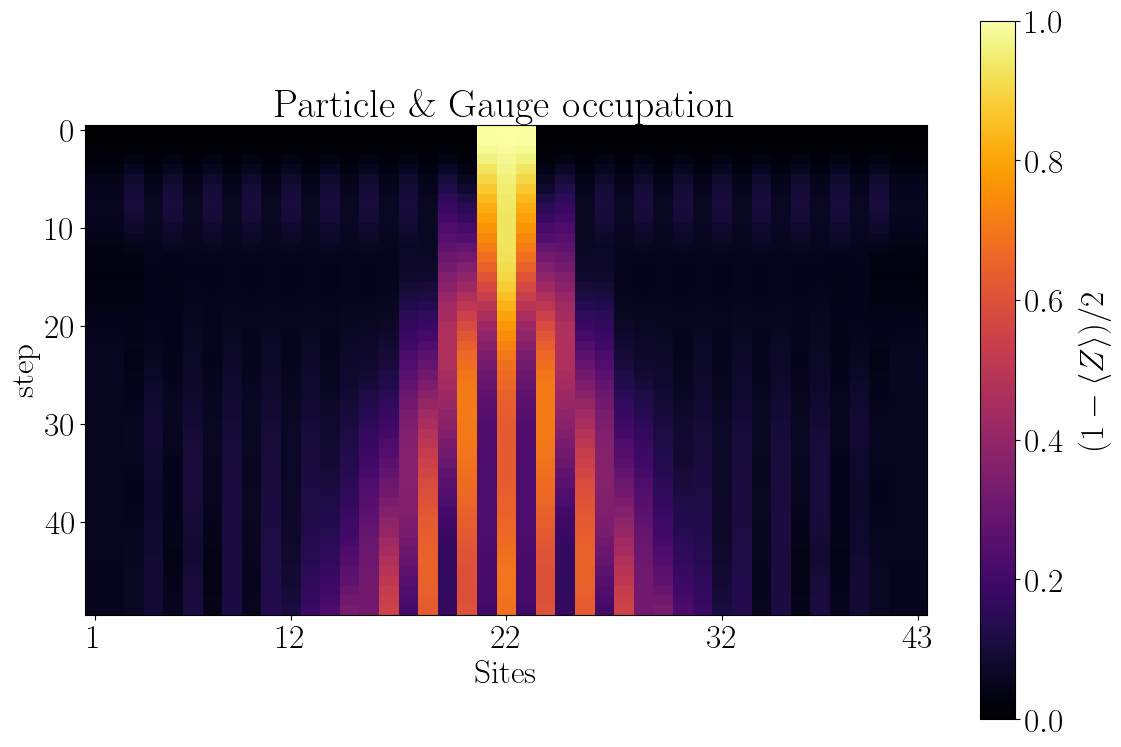

In [ ]:
from z2chain.plotting import x_t_plot, save_site_gauge_observable_matrix, load_site_gauge_observable_matrix
from z2chain.circs import particle_pair_quench_simulation_circuits
from utils.sexec import execute_simulation_estimator_batch
import os

estimator_options = {
    "default_precision": 0
}

mps_simulator_options = {
    "method": "matrix_product_state",
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-8,
    "max_parallel_threads": 8,
    "max_parallel_experiments": 8
}

filepath = f"Results/tncirc_z2pairquench_maxt_{final_time}_steps_{layers}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_bd_{mps_simulator_options["matrix_product_state_max_bond_dimension"]}_prec_{estimator_options['default_precision']}.txt"

if os.path.exists(filepath):
    tn_site_gauge_observable_matrix = load_site_gauge_observable_matrix(filepath)
else:
    logical_circs = particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, layers, measure_every_layers)
    observables_generating_funcs = [partial(local_pauli_z, qubit_ind=i) for i in range(2*L-1)]
    tn_site_gauge_observable_matrix = execute_simulation_estimator_batch(mps_simulator_options, estimator_options, logical_circs, observables_generating_funcs)
    save_site_gauge_observable_matrix(tn_site_gauge_observable_matrix, filepath)

x_t_plot(tn_site_gauge_observable_matrix, filepath=os.path.join("Plots", os.path.basename(os.path.split(filepath)[1])) + ".png")

In [ ]:
from z2chain.plotting import discrepancies_plot

discrepancies_plot(tn_site_gauge_observable_matrix, jobs)